In [ ]:
# Importamos las librerías necesarias para el análisis de los datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Cargamos los datos en DataFrames

cash_request = pd.read_csv('./project_dataset/extract - cash request - data analyst.csv')
fees = pd.read_csv('./project_dataset/extract - fees - data analyst - .csv')

In [ ]:
df = cash_request.join(fees[['total_amount', 'type', 'category', 'charge_moment']]) # Juntamos los dos datasets en un solo dataframe
df.head()

### Tratamiento del dataframe

In [ ]:
# Comprobamos que los datos se han cargado correctamente y visualizamos las primeras filas de cada DataFrame
# para hacernos una idea de la estructura de los datos y de las columnas que contienen los DataFrames

# Comprobamos si hay valores nulos en el DataFrame df
df.isnull().sum()

In [56]:
# Visualizamos las primeras filas del DataFrame cash_request
df.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,total_amount,type,category,charge_moment,mes_cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,...,regular,NaN,NaN,NaN,NaN,5.0,instant_payment,money_back,after,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,...,regular,NaN,NaN,NaN,NaN,5.0,incident,rejected_direct_debit,after,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,...,regular,NaN,NaN,NaN,NaN,5.0,instant_payment,money_back,after,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,...,regular,NaN,NaN,NaN,NaN,5.0,instant_payment,money_back,after,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,...,regular,NaN,NaN,NaN,NaN,5.0,instant_payment,money_back,after,2020-05


In [ ]:
# Información sobre el DataFrame cash_request
df.info()

In [ ]:
# Estadísticas descriptivas del DataFrame cash_request, usamos transpose para que se visualicen mejor
df.describe().transpose()

In [ ]:
# Histograma de la variable amount
sns.histplot(df['amount'], bins=30) 

plt.title('Distribución de amount') # Título del histograma
plt.xlabel('amount')                # Etiqueta del eje x
plt.ylabel('Frecuencia')            # Etiqueta del eje y
plt.show()                          # Mostramos el histograma

In [ ]:
# Scatterplot de la variable amount en función de user_id
sns.scatterplot(x='user_id', y='amount', data=df)

plt.title('amount por user_id') # Título del scatterplot
plt.xlabel('user_id')           # Etiqueta del eje x
plt.ylabel('amount')            # Etiqueta del eje y
plt.show()                      # Mostramos el scatterplot

### **0. Creación de las cohortes por mes:** Basado en el mes de creación de la primera transacción (created_at)

1. Convertir la columna created_at a formato datetime
2. Crear una nueva columna 'mes_cohorte' con el mes de la columna 'created_at'

In [ ]:
# Convertir la columna created_at a formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])

df.info() # Comprobamos que la columna created_at se ha convertido a formato datetime

In [ ]:
# Crear una nueva columna 'mes_cohorte' con el mes de la columna 'created_at'
df['mes_cohorte'] = df['created_at'].dt.to_period('M')  

df.head() # Visualizamos las primeras filas del DataFrame df para comprobar que se ha creado la nueva columna

### **1. Frecuencia de Uso del Servicio:** Comprender con qué frecuencia los usuarios de cada cohorte utilizan los servicios de adelanto de efectivo de IronHack Payments a lo largo del tiempo.

1. Agrupamos la columna mes_cohorte y aplicamos la función 'agg' para agregar diferentes metricas

En nuestro caso añadimos la columna 'id' con la cantidad de estas en cada 'mes_cohorte'

In [ ]:
# Agrupamos la columna mes_cohorte y aplicamos la función 'agg' para agregar diferentes metricas

cohortes_count = df.groupby(by='mes_cohorte').agg({ 
  'id': 'count', # Contamos el número de transacciones por mes de cohorte
  }).rename(columns={'id': 'n_transacciones'})
cohortes_count

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2019-11'),
  Text(1, 0, '2019-12'),
  Text(2, 0, '2020-01'),
  Text(3, 0, '2020-02'),
  Text(4, 0, '2020-03'),
  Text(5, 0, '2020-04'),
  Text(6, 0, '2020-05'),
  Text(7, 0, '2020-06'),
  Text(8, 0, '2020-07'),
  Text(9, 0, '2020-08'),
  Text(10, 0, '2020-09'),
  Text(11, 0, '2020-10'),
  Text(12, 0, '2020-11')])

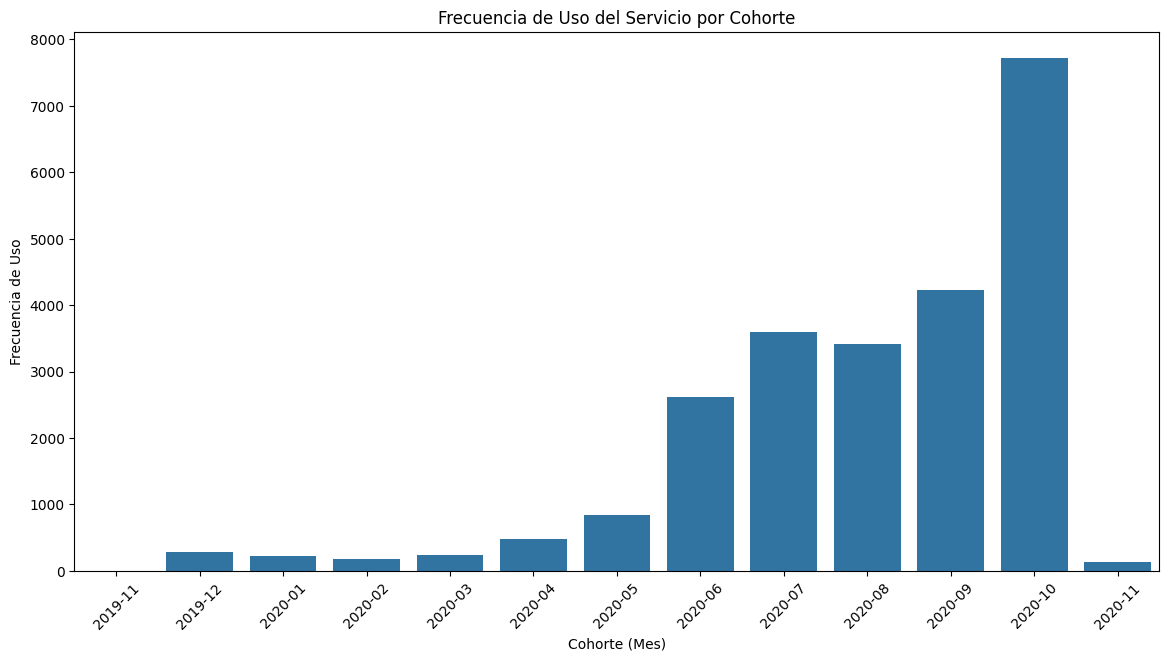

In [55]:
plt.figure(figsize=(14, 7)) # Tamaño de la figura

# Barplot de la variable id en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='n_transacciones', data=cohortes_count)   # 
plt.title('Frecuencia de Uso del Servicio por Cohorte')     # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Frecuencia de Uso')                             # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

Desde el inicio del servicio se observa un aumento de la frecuencia del uso progresiva, hasta la cohorte del 10-2020 que muestra una frecuencia mucho más elevada que el resto. Y luego la del 11-2020 vuelve a niveles muy bajos.

### **2. Tasa de Incidentes:** Determinar la tasa de incidentes, enfocándose específicamente en los incidentes de pago, para cada cohorte. Identificar si hay variaciones en las tasas de incidentes entre diferentes cohortes.

In [ ]:
# Devuelve un array de las categorias unicas de la columna 'status' enne

df['status'].unique()

Entendemos que los incidentes de pago son los valores 'rejected' de la columna 'status'
1. Calcular el numero de 'rejected' en la columna 'status'
2. El total de transacciones lo tenemos del punto anterior
3. Calcular el porcentaje de 'rejected' sobre el total

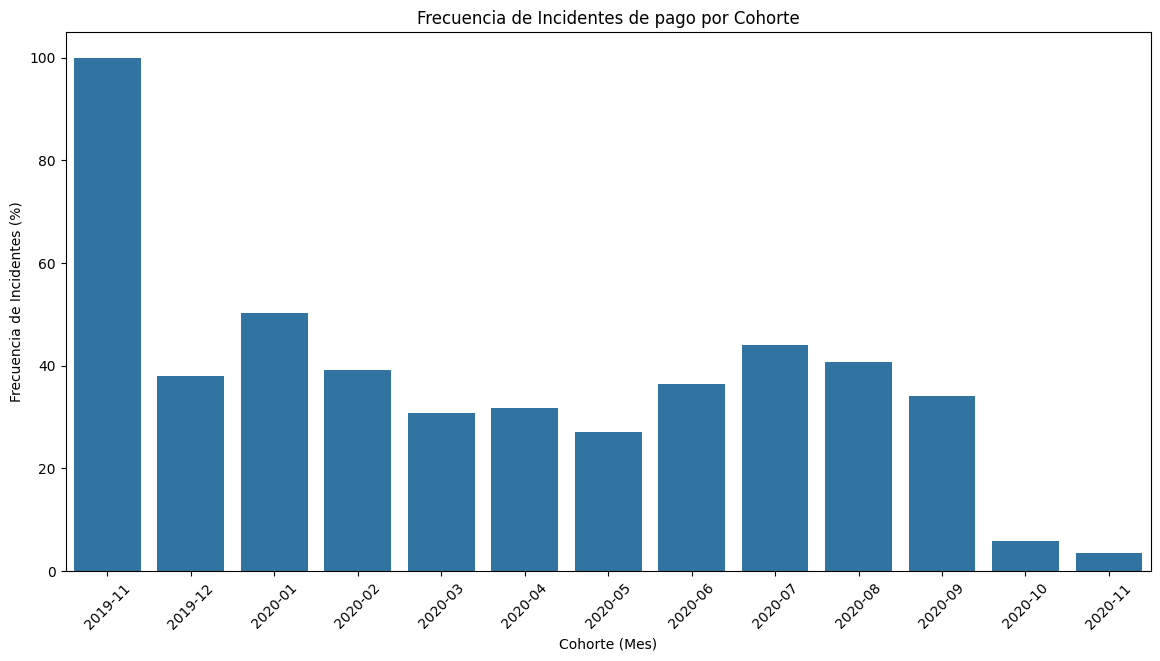

In [57]:
# Guardamos las filas del dataframe donde el 'status' == 'rejected' en un nuevo dataframe llamado 'incidentes'
incidentes = df[df['status'] == 'rejected']

# Agrupamos la columna mes_cohorte y aplicamos la función 'agg' para agregar diferentes metricas
incidentes_count = incidentes.groupby(by='mes_cohorte').agg({ 
  'id': 'count'   # Contamos el número de incidentes
}).rename(columns={'id': 'n_incidentes'})

cohortes_incidentes = cohortes_count.join(incidentes_count).fillna(1) # Crear dataframe agrupando los dataframes 'cohortes_count' y 'incidentes_count'
cohortes_incidentes['tasa_incidentes'] = (cohortes_incidentes['n_incidentes'] / cohortes_incidentes['n_transacciones'])*100 # Añadir columna con la tasa de incidentes en %

porcentaje = (incidentes_count / cohortes_count) * 100

plt.figure(figsize=(14, 7)) # Tamaño de la figura

# Barplot de la variable id en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='tasa_incidentes', data=cohortes_incidentes)   # 
plt.title('Frecuencia de Incidentes de pago por Cohorte')   # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Frecuencia de Incidentes (%)')                  # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

plt.show()

### 3. **Ingresos Generados por la Cohorte:** Calcular el total de ingresos generados por cada cohorte a lo largo de los meses para evaluar el impacto financiero del comportamiento de los usuarios.

(Entendemos que los ingresos generados son los que muestra la columna total_amount del dataset fees)

In [ ]:
# Agrupamos la columna mes_cohorte y aplicamos la función 'agg' para agregar diferentes metricas
ingresos_sum = df.groupby(by='mes_cohorte').agg({ 
  'total_amount': 'sum'   # Contamos el número de transacciones por mes de cohorte
}).rename(columns={'total_amount': 'ingresos'})

df_ingresos = cohortes_incidentes.join(ingresos_sum).fillna(1)
df_ingresos

In [ ]:
plt.figure(figsize=(14, 7)) # Tamaño de la figura

# Barplot de la variable ingresos en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='ingresos', data=df_ingresos)   # 
plt.title('Ingresos totales por Cohorte')                   # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Ingresos')                                      # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

plt.show()

### 4. **Nueva Métrica Relevante:** Proponer y calcular una nueva métrica relevante que brinde perspectivas adicionales sobre el comportamiento de los usuarios o el rendimiento de los servicios de IronHack Payments.

In [ ]:
df_ingresos

hacer matriz de correlacion: plantear algunas hipotesis
hacer un par de test de las hipotesis, prueba de correlacion de pearson

que variables influyen mas en los ingresos¿¿¿???

sacar alguna conslusion


Luego limpiar datos y volver a hacerlo

In [ ]:
# Creamos una nueva columna para ver la relación entre n_transacciones y tasa de incidentes para saber si a mas transacciones mas incidentes.
df_ingresos['tasa_incidentes_por_transaccion'] = df_ingresos['tasa_incidentes'] / df_ingresos['n_transacciones']
df_ingresos

In [ ]:
# Hipotesis: A mas numero de transacciones tenemos mas tasa incidentes por que el sistema tiene mas carga y falla mas.

# Cálculo de la correlación de Pearson
corr_coef, p_value = stats.pearsonr(df_ingresos['n_transacciones'], df_ingresos['tasa_incidentes'])

print(f"Coeficiente de correlación: {corr_coef}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay evidencia suficiente para decir que la correlación entre n_transacciones y tasa_incidentes es significativa.")
else:
    print("No podemos rechazar la hipótesis nula. No hay evidencia suficiente para decir que la correlación entre n_transacciones y tasa_incidentes es significativa.")

In [ ]:
correlation_matrix = df_ingresos.corr()
correlation_matrix

In [ ]:
# Hipotesis: Extiste una fuerte correlacion entre el numero de transacciones y los ingresos (0.983923) cosa que indica que a mayor numero de transacciones aumentan los ingresos.

# Cálculo de la correlación de Pearson
corr_coef, p_value = stats.pearsonr(df_ingresos['n_transacciones'], df_ingresos['ingresos'])

print(f"Coeficiente de correlación: {corr_coef}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay evidencia suficiente para decir que la correlación entre n_transacciones y ingresos es significativa.")
else:
    print("No podemos rechazar la hipótesis nula. No hay evidencia suficiente para decir que la correlación entre n_transacciones y ingresos es significativa.")

In [ ]:
df_ingresos

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Graficar barras para ingresos, número de transacciones y número de incidentes
df_ingresos[['ingresos', 'n_transacciones', 'n_incidentes']].plot(kind='bar', ax=ax1)

# Configuración de título y etiquetas para el gráfico de barras
ax1.set_title('Ingresos, Número de Transacciones y Número de Incidentes por Mes')
ax1.set_xlabel('Mes Cohorte')
ax1.set_ylabel('Cantidad')

# Crear figura y ejes para el gráfico de línea
fig, ax2 = plt.subplots(figsize=(14, 7))

# Graficar la línea para tasa de incidentes
df_ingresos['tasa_incidentes'].plot(kind='line', marker='o', linestyle='-', color='red', ax=ax2)

# Configuración de título y etiquetas para el gráfico de línea
ax2.set_title('Tasa de Incidentes por Mes')
ax2.set_xlabel('Mes Cohorte')
ax2.set_ylabel('Tasa de Incidentes')

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

In [ ]:
# Graficar la líneas para tasa de incidentes y numero de transacciones
fig, ax1 = plt.subplots(figsize=(14, 7))


df_ingresos['tasa_incidentes'].plot(kind='line', marker='o', linestyle='-', color='red', ax=ax1)
df_ingresos['n_transacciones'].plot(kind='line', marker='o', linestyle='-', color='green', ax=ax1)

ax1.set_title('Tasa de Incidentes vs numero de transacciones')
ax1.set_xlabel('Mes Cohorte')
ax1.set_ylabel('Tasa de Incidentes / Numero de transacciones')
ax1.legend()

plt.tight_layout()
plt.show()


### **Limpieza del dataframe**

Durante el analisis de los datos se han encontrado un gran numero de valores missing, así como valores outlier, de manera que hay que proceder a la limpieza de los datos para poder llevar a cabo un analisis con datos de mayor calidad.

In [ ]:
# Detectar las filas en las que el total_amount es = a 10
df['total_amount'].unique()
filtered_df_by_total_amount = df[df['total_amount'] == 10]
filtered_df_by_total_amount

In [ ]:
# Limpiar los valores missing de las columnas que usamos ['total_amount', 'type', 'category', 'charge_moment']
df.isnull().sum()

In [ ]:
df.head()

#### Limpieza de los valores nominales: 'type', 'category', 'charge_moment'

In [ ]:
# df['charge_moment'].unique()
# df['category'].unique()
# df['type'].unique()

In [ ]:
df['charge_moment'] = df['charge_moment'].fillna('not_specified')
df['category'] = df['category'].fillna('not_specified')
df['type'] = df['type'].fillna('not_specified')

df.isnull().sum()

In [ ]:
df_handle = df[df['charge_moment'] == 'not_specified']

df_handle['status'].value_counts()

In [ ]:
df_handle = df[df['category'] == 'not_specified']

df_handle['status'].value_counts()

In [ ]:
df_handle = df[df['type'] == 'not_specified']

df_handle['status'].value_counts()

In [ ]:
df.isnull().sum()

In [ ]:
# Reemplazar 'not_specified' con 'unknown'
df['charge_moment'] = df['charge_moment'].replace('not_specified', 'money_back')
df['category'] = df['category'].replace('not_specified', 'money_back')
df['type'] = df['type'].replace('not_specified', 'money_back')


In [ ]:
# df['charge_moment'].unique()
# df['category'].unique()
# df['type'].unique()

#### Limpieza de los valores numericos: 'total_amount'

In [ ]:
df.isnull().sum()

In [ ]:
df['total_amount'].mean()

In [ ]:
df['total_amount'].median()

In [ ]:
df['type'] = df['type'].fillna(5)
df.isnull().sum()

Detectar y ajustar los valores outlier

- De las columnas que hemos usado buscar los outlier y ajustarlos o eliminarlos
- Hacer boxplot o histograma, definir los outlier y PUM!!! matarlos!!! 

In [ ]:
# Configurar el tamaño de la figura
plt.figure()

# Crear el histograma utilizando un barplot (countplot)
sns.boxplot(x='total_amount', data=df)

# Configurar el título y las etiquetas de los ejes
plt.title('total_amount')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Rotar los nombres del eje X
plt.xticks(rotation=45)

# Mostrar el histograma
plt.show()

In [ ]:
df = df[df['total_amount'] != 10] # Eliminamos el valor outlier de la columna 'total_amount'

In [ ]:
plt.figure()

# Crear el boxplot
sns.boxplot(x='total_amount', data=df)

# Configurar el título y las etiquetas de los ejes
plt.title('total_amount')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Rotar los nombres del eje X
plt.xticks(rotation=45)

plt.show()

In [ ]:
plt.figure()

# Crear el boxplot
sns.boxplot(x='type', data=df)

# Configurar el título y las etiquetas de los ejes
plt.title('type')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Rotar los nombres del eje X
plt.xticks(rotation=45)

plt.show()

In [ ]:
plt.figure()

# Crear el boxplot
sns.boxplot(x='category', data=df)

# Configurar el título y las etiquetas de los ejes
plt.title('category')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Rotar los nombres del eje X
plt.xticks(rotation=45)

plt.show()

In [ ]:
plt.figure()

# Crear el boxplot
sns.boxplot(x='charge_moment', data=df)

# Configurar el título y las etiquetas de los ejes
plt.title('charge_moment')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Rotar los nombres del eje X
plt.xticks(rotation=45)

plt.show()

#### Por ultimo hacer la limpieza del mes 2019-11, ya que solo contiene una variable

In [ ]:
df_ingresos

In [ ]:
df_ingresos = df_ingresos[df_ingresos['n_transacciones'] != 1]
df_ingresos

# Gráficos despues de la limpieza

In [ ]:
plt.figure(figsize=(8, 6))

# Histograma de la variable amount
sns.histplot(df['amount'], bins=30, kde=True) 

plt.title('Distribución de amount') # Título del histograma
plt.xlabel('amount')                # Etiqueta del eje x
plt.ylabel('Frecuencia')            # Etiqueta del eje y
plt.show()                          # Mostramos el histograma

In [ ]:
# Scatterplot de la variable amount en función de user_id
sns.scatterplot(x='user_id', y='amount', data=df)

plt.title('amount por user_id') # Título del scatterplot
plt.xlabel('user_id')           # Etiqueta del eje x
plt.ylabel('amount')            # Etiqueta del eje y
plt.show()                      # Mostramos el scatterplot

In [ ]:
plt.figure(figsize=(14, 7)) # Tamaño de la figura

# Barplot de la variable id en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='n_transacciones', data=df_ingresos)   # 
plt.title('Frecuencia de Uso del Servicio por Cohorte')     # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Frecuencia de Uso')                             # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

In [ ]:
# Barplot de la variable id en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='tasa_incidentes', data=df_ingresos)   # 
plt.title('Frecuencia de Incidentes de pago por Cohorte')   # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Frecuencia de Incidentes (%)')                  # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

plt.show()

In [ ]:
plt.figure(figsize=(14, 7)) # Tamaño de la figura

# Barplot de la variable ingresos en función de mes_cohorte
sns.barplot(x='mes_cohorte', y='ingresos', data=df_ingresos)   # 
plt.title('Ingresos totales por Cohorte')                   # Título del barplot
plt.xlabel('Cohorte (Mes)')                                 # Etiqueta del eje x
plt.ylabel('Ingresos')                                      # Etiqueta del eje y
plt.xticks(rotation=45)                                     # Los nombres del eje X, los ponemos a 45 grados

plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Graficar barras para ingresos, número de transacciones y número de incidentes
df_ingresos[['ingresos', 'n_transacciones', 'n_incidentes']].plot(kind='bar', ax=ax1)

# Configuración de título y etiquetas para el gráfico de barras
ax1.set_title('Ingresos, Número de Transacciones y Número de Incidentes por Mes')
ax1.set_xlabel('Mes Cohorte')
ax1.set_ylabel('Cantidad')

# Crear figura y ejes para el gráfico de línea
fig, ax2 = plt.subplots(figsize=(14, 7))

# Graficar la línea para tasa de incidentes
df_ingresos['tasa_incidentes'].plot(kind='line', marker='o', linestyle='-', color='red', ax=ax2)

# Configuración de título y etiquetas para el gráfico de línea
ax2.set_title('Tasa de Incidentes por Mes')
ax2.set_xlabel('Mes Cohorte')
ax2.set_ylabel('Tasa de Incidentes')

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

In [ ]:
# Graficar la líneas para tasa de incidentes y numero de transacciones
fig, ax1 = plt.subplots(figsize=(14, 7))


df_ingresos['tasa_incidentes'].plot(kind='line', marker='o', linestyle='-', color='red', ax=ax1)
df_ingresos['n_transacciones'].plot(kind='line', marker='o', linestyle='-', color='green', ax=ax1)

ax1.set_title('Tasa de Incidentes vs numero de transacciones')
ax1.set_xlabel('Mes Cohorte')
ax1.set_ylabel('Tasa de Incidentes / Numero de transacciones')
ax1.legend()

plt.tight_layout()
plt.show()
